In [1]:
# Зададим стили
from IPython.display import HTML
with open('./styles/overall.css', 'r') as stl:
    style = stl.read()
HTML(style)

In [2]:
# Графические утилитки
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [3]:
# Библиотеки для работы с данными
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import boxcox

from src.tests import (dickey_fuller_test,
                       ljung_box_test
                      )
from src.utils import (exponential_smoothing,
                       double_exponential_smoothing
                      )

In [4]:
# Магия для отключения предупреждений
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Импорт данных
from src.data import (temperatures, 
                      beer, 
                      beer_df,
                      passengers,
                      oxygen
                      )

In [6]:
# Настройка графической утилиты
width = 15
height = 8
plt.rcParams['figure.figsize'] = (width, height)
plt.rcParams['axes.titlesize'] = 25

# Настройки отображения
line_width = 1
dot_size = 5

![Logo](img/mephi-logo.png)

<h1>Характеристики временного ряда и визуальный анализ</h1><br>
<span class="text_common"><b>Определение: <i>временным рядом</i></b> называются собранные в разные моменты времени статистические данные о значении каких-либо параметров исследуемого процесса.</span>
<hr>
<h2>Сезонность (кратко)</h2><br>
<span class="text_common"><b>Определение: <i>сезонностью временного ряда</i></b> называют наблюдаемые в нём периодические колебания.<br>
Рассмотрим пример временного ряда, показывающего ежедневные значения минимальной температуры воздуха.</span>

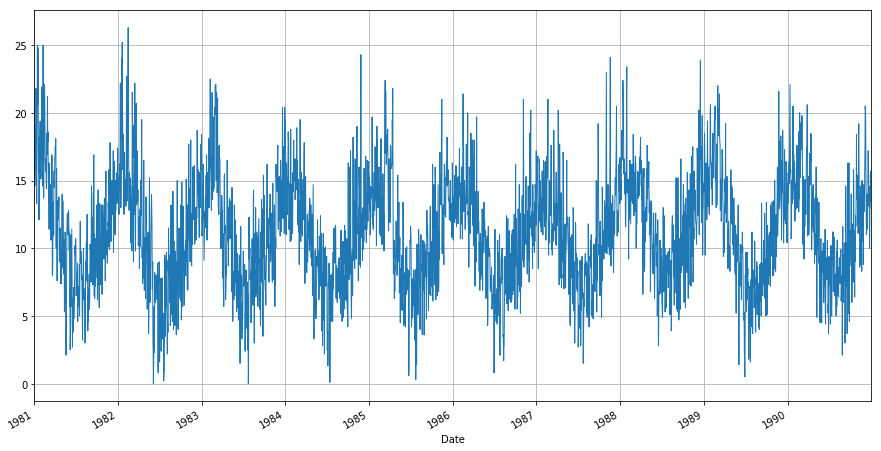

In [7]:
# pandas.Series хорошо ладит с pyplot и имеет методы для посторения различных графиков
temperatures.plot(x=0, y=1, linewidth=line_width)
plt.grid()

<span class="text_common"><b>Основные выводы:</b> как можно наблюдать по визуальному предствалению временного ряда, отчетливо наблюдается снижение минимальной температуры воздуха в летние месяцы и повышение её в зимнее время.</span>
<hr>
<h3>Способы выявления сезонности</h3>
<h4>Автокорреляционная функция (ACF) и частная автокорреляционная функция (PACF)</h4><br>
<span class="text_common"><b>Определения: </b></span>

$${\normalsize ACF(\tau) = {\Large \frac{c(\tau)}{c(0)}}}$$
${\normalsize c(\tau) = M[(Y_{\tau} - \mu)(Y_{t-\tau} - \mu)],\ \mu = M[Y_{t}]}$<span class="text_common"> - математическое ожидание стационарного процесса </span>${\large Y_{t}}$<span class="text_common">.</span>


$${\normalsize PACF(\tau) = {\Large \pi(\tau) = \pi_{Y_{t}Y_{t-\tau}|Y_{t-1}...Y_{t-\tau+1}}}}$$
${\normalsize \pi(\tau)}$<span class="text_common"> - коэффициент частной корреляции между </span>${\large Y_{t}}$<span class="text_common"> и </span>${\large Y_{t-\tau}}$<span class="text_common"> при устранении влияния переменных </span> ${\large Y_{t-1}...Y_{t-\tau+1}}$<span class="text_common">.</span>

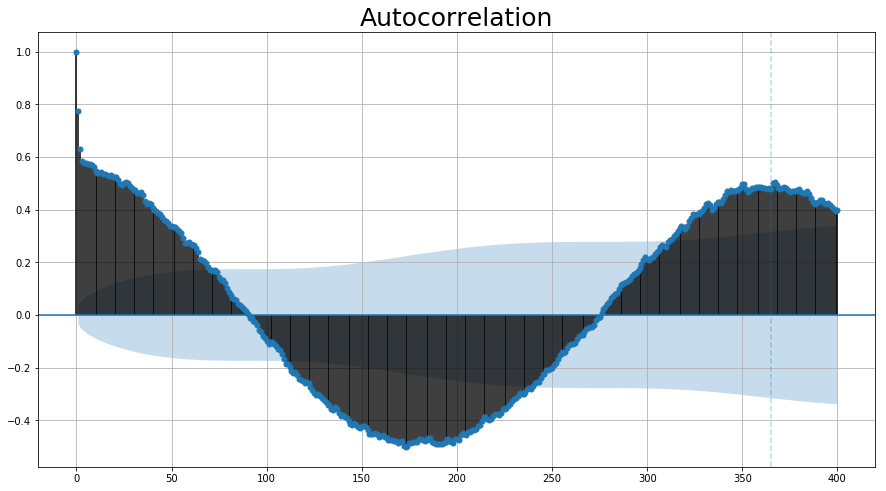

In [8]:
# 'plot_acf' - функция из библиотеки statsmodels.graphics.tsaplots
plot_acf(temperatures, lags=400)
plt.axvline(x=365, ymin=0, ymax=1, ls='dashed', alpha=0.3), plt.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> глядя на график, несложно заметить следующий факт, что около отметки 365 (вертикальная черта в правой части графика) значения ACF начинают повторять те, что находятся вблизи нуля. Таким образом, сезонность временного ряда имеет период, равный 365, что в целом интуитивно понятно.</span>

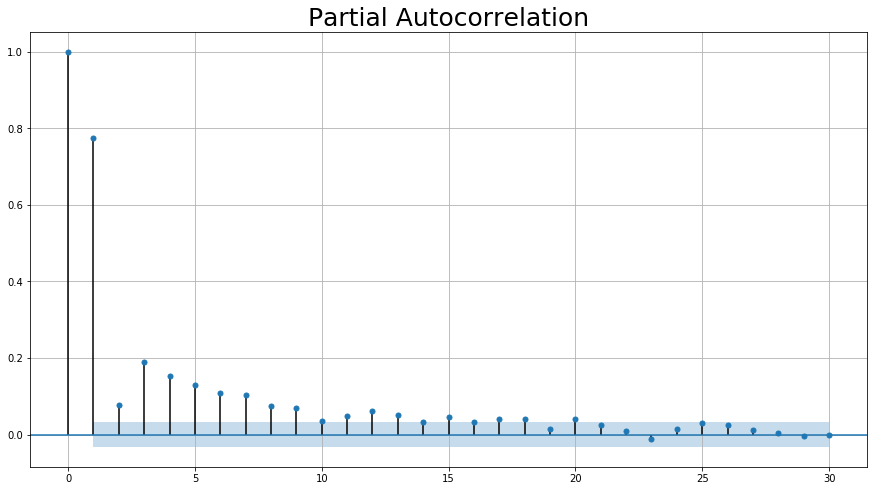

In [9]:
# 'plot_pacf' - функция из библиотеки statsmodels.graphics.tsaplots
plot_pacf(temperatures, lags=30)
plt.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> наблюдается спад значений приблизительно до значения 20, что означает ...</span>

<h4>Lag plot</h4><br>
<span class="text_common"><b>Определение: <i>Lag plot</i></b> - фактически это scatter-plot для двух случайных величин: </span>$\large{Y_{t}}$<span class="text_common"> и </span>$\large{Y_{t\pm\tau}}$

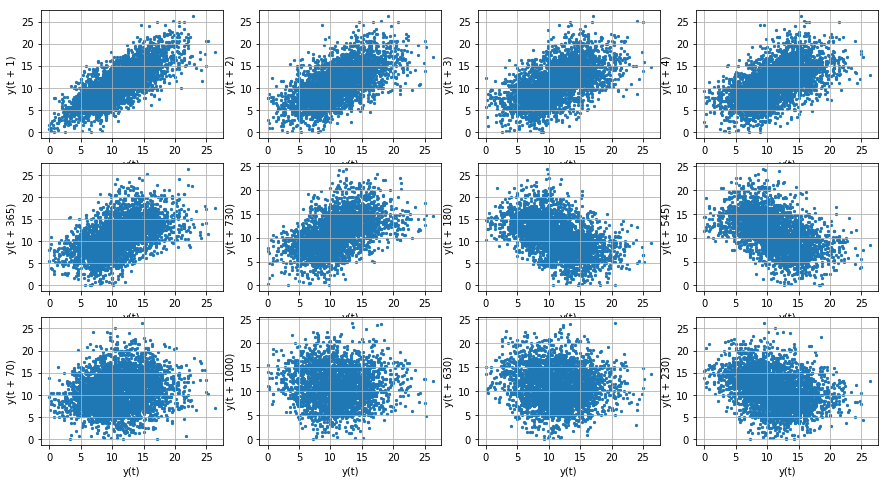

In [10]:
lag_plot_data = {
    1: (0, 0), 2: (0, 1), 3: (0, 2), 4: (0, 3), 
    365: (1, 0), 730: (1, 1), 180: (1, 2), 545: (1, 3),
    70: (2, 0), 1000: (2, 1), 630: (2, 2), 230: (2, 3)  
}

_, plots = plt.subplots(3, 4)
for lag, (row, col) in lag_plot_data.items():
    lag_plot(temperatures, lag=lag, s=dot_size, ax=plots[row][col]), plots[row][col].grid()
    
plt.show()

<span class="text_common"><b>Основные выводы:</b> на данных графиках можно видеть сильную корреляцию при малых лагах (1, 2, 3, 4), что обусловлено малой разницей близких значений. Также сильная положительная корреляция наблюдается при значениях, кратных 365, в то же время можно видеть сильную отрицательную корреяцию при лаге, кратном 180, но не кратном 365 (то есть временной ряд имеет сезонность с периодом 365). При некоторых других значениях лага корреляции не наблюдается.</span>

<hr><h2>Тренд</h2><br>
<span class="text_common"><b>Определение: <i>трендом</i></b> называется тенденция изменения показателей временного ряда. Тренды могут быть описаны различными функциями — линейными, степенными, экспоненциальными и т.д.<br>
В качестве примера рассмотрим следующий временной ряд: суммарный квартальный объем проданного пива в Австралии (в млн. литров), начиная с первого квартала 1956 года и заканчивая вторым кварталом 2010 года.</span>

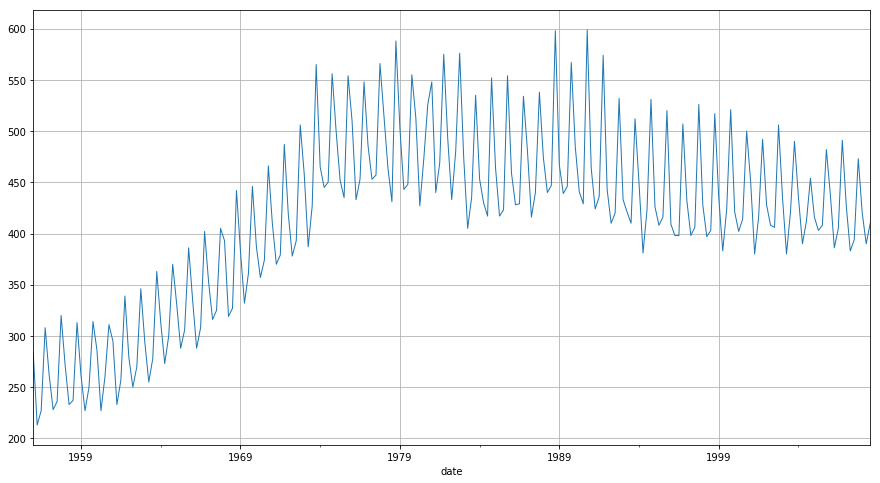

In [11]:
beer.plot(x=0, y=1, linewidth=line_width)
plt.grid()

<span class="text_common"><b>Основные выводы:</b> на данном графике можно наблюдать тренд, который можно описать квадратичной функцией. Кроме того, если рассмотреть только период от начала до примерно 1975 года, то можно заметить выраженный линейный тренд.</span>
<hr>

<h3>Как ещё можно сделать вывод о виде тренда?</h3><br>

<span class="text_common">Построим диаграммы Box-and-whisker для временного ряда минимальных температур для каждого периода сезонности. Получим следующую картинку:</span>

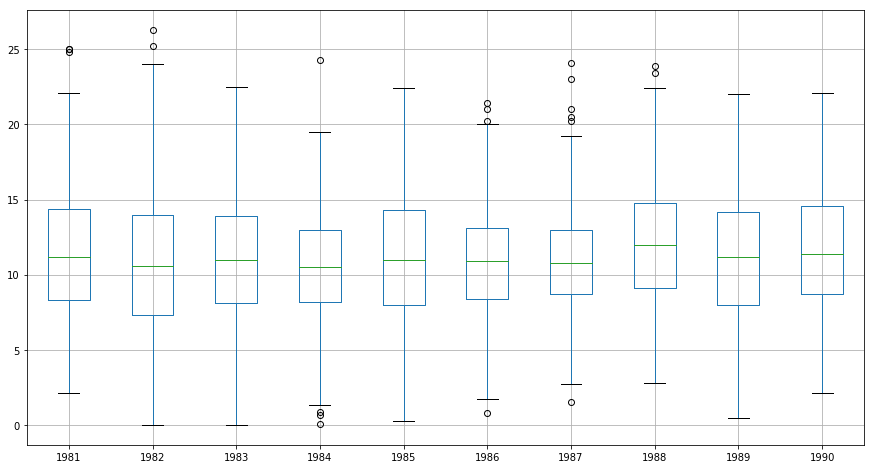

In [12]:
groups = temperatures.groupby(pd.Grouper(freq='Y'))
pd.DataFrame({name.year: group.values for name, group in groups}).boxplot()
plt.show()

<span class="text_common"><b>Основные выводы:</b> несложно увидеть, что диаграммы располагаются на одном и том же уровне, что означает линейный тренд, с нулевым значимым коэффициентом.
    
Аналогичные диаграммы построим и для временного ряда суммарного квартального объема проданного пива:</span>

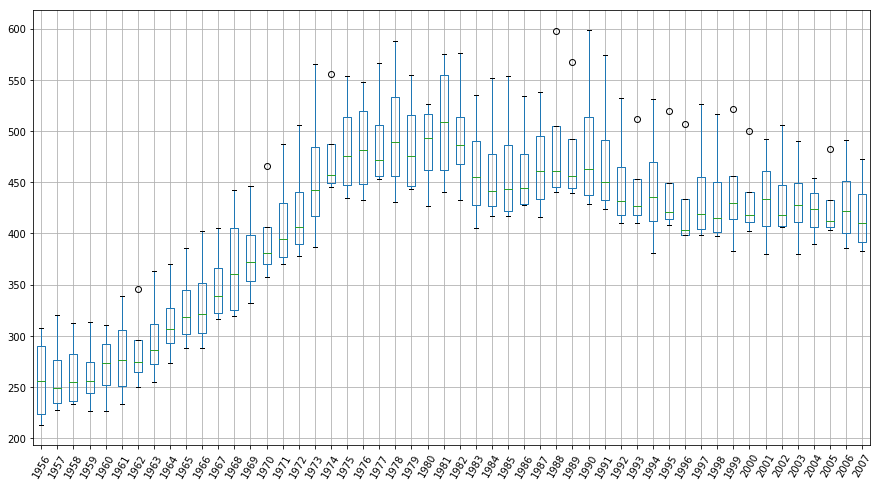

In [13]:
groups = beer.groupby(pd.Grouper(freq='Y'))
pd.DataFrame({name.year: group.values for name, group in groups if len(group.values) > 3}).boxplot()
plt.xticks(rotation=60)
plt.show()

<span class="text_common"><b>Основные выводы:</b> по данным диаграммам можно заметить всё то же самое, касательно тренда, что было сказано выше - тренд напоминает квадратичную функцию.</span>

<h3>Выделение тренда</h3><br>

<span class="text_common">Для подтверждения догадок построим график тренда поверх временного ряда.

Стоит отметить, что дисперсия сильно не разнится в зависимости от времени, а значит можно принять аддитивную модель декомпозиции временного ряда</span>

In [14]:
# Подготовка данных - установка столбца индексов
beer_df['date'] = pd.to_datetime(beer_df['date'])
beer_df.set_index('date', inplace=True)

<h4>statsmodels.tsa.seasonal.seasonal_decompose</h4>

In [15]:
# Тренд можно выделить из ряда функцией 'seasonal_decompose' из пакета statsmodels
decomposition = seasonal_decompose(beer_df, model='additive')
detrend_1 = [value - trend for value, trend in zip(beer_df['value'], decomposition.trend.values)]

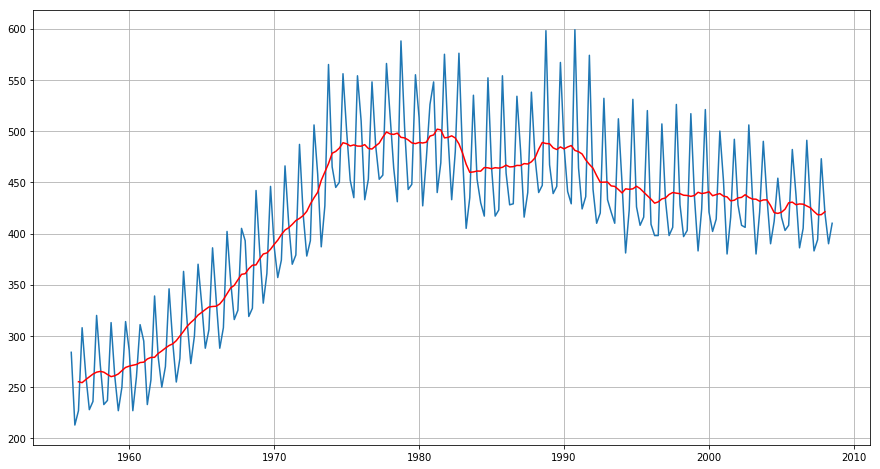

In [16]:
plt.plot(beer_df.index, beer_df['value'])
plt.plot(decomposition.trend.index, decomposition.trend.values, c='r')
plt.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> нетрудно увидеть, что догадки про вид тренда подтвердились снова - он действительно похож на квадратичную функцию, если его сгладить.</span>

<h4>Скользящее среднее</h4>

In [17]:
moving_average = beer_df['value'].rolling(window=7).mean()
detrend_2 = [value - trend for value, trend in zip(beer_df['value'], moving_average)]

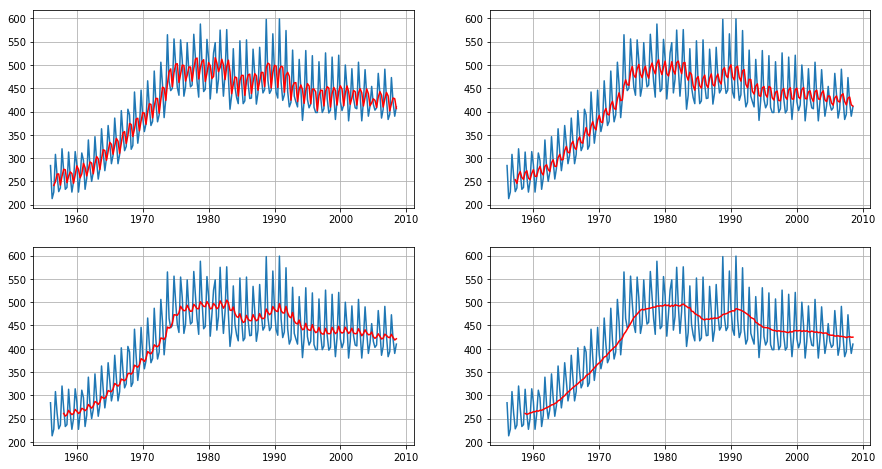

In [18]:
ma_plot_data = {
    3: (0, 0), 6:  (0, 1),
    9: (1, 0), 12: (1, 1)
}

_, ax = plt.subplots(2, 2)
for wnd, (row, col) in ma_plot_data.items():
    ax[row][col].plot(beer_df.index, beer_df['value'])
    ax[row][col].plot(beer_df['value'].rolling(window=wnd).mean(), c='r')
    ax[row][col].grid()
    
plt.show()

<span class="text_common"><b>Основные выводы:</b> чем больше окно для подсчета скользящего среднего, тем более сглаженным получается выделенный тренд.</span>

<h4>Простое экспоненциальное сглаживание</h4>

In [19]:
exp_smoothing = exponential_smoothing(beer_df, alpha=0.3)
detrend_3 = [value - trend for value, trend in zip(beer_df['value'], exp_smoothing)]

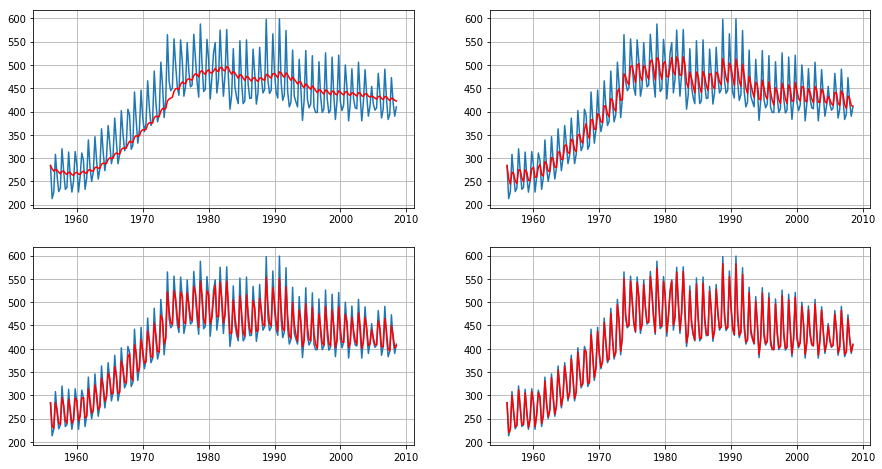

In [20]:
es_plot_data = {
    0.1: (0, 0), 0.4: (0, 1),
    0.7: (1, 0), 0.9: (1, 1)
}

_, ax = plt.subplots(2, 2)
for alpha, (row, col) in es_plot_data.items():
    ax[row][col].plot(beer_df.index, beer_df['value'])
    ax[row][col].plot(beer_df.index, exponential_smoothing(beer_df, alpha=alpha), c='r')
    ax[row][col].grid()
    
plt.show()

<span class="text_common"><b>Основные выводы:</b> параметр </span>$\large{\alpha}$<span class="text_common"> влияет на сглаживание выделенного тренда следующим образом: чем он меньше, тем более сглаженным будет тренд.</span>

<h4>Двойное экспоненциальное сглаживание (метод Холта)</h4>

In [21]:
double_exp_smoothing = double_exponential_smoothing(beer_df, alpha=0.4, beta=0.3)
detrend_4 = [value - trend for value, trend in zip(beer_df['value'], double_exp_smoothing)]

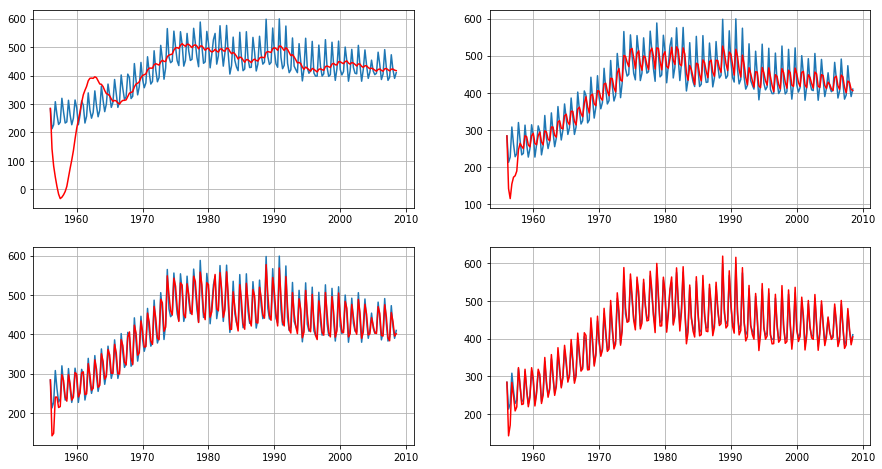

In [22]:
des_plot_data = {
    0.1: (0, 0), 0.4: (0, 1),
    0.7: (1, 0), 0.9: (1, 1)
}

_, ax = plt.subplots(2, 2)
for alpha, (row, col) in des_plot_data.items():
    ax[row][col].plot(beer_df.index, beer_df['value'])
    ax[row][col].plot(beer_df.index, double_exponential_smoothing(beer_df, alpha=alpha, beta=0.3)[:-1], c='r')
    ax[row][col].grid()
    
plt.show()

<span class="text_common"><b>Основные выводы:</b> параметры </span>$\large{\alpha}$<span class="text_common"> и </span>$\large{\beta}$<span class="text_common"> влияют на само сглаживание. При этом чем меньше коэффициенты, тем более сглаженный получается тренд.</span>

<span class="text_common">Теперь можно вычесть трендовую составляющую из временного ряда.</span>

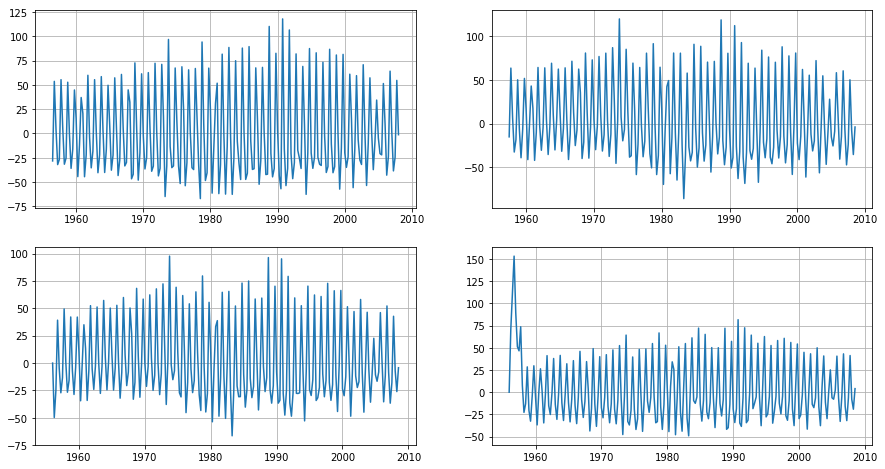

In [23]:
detrend_plot_data = {
    1: (0, 0), 2: (0, 1),
    3: (1, 0), 4: (1, 1)
}

_, ax = plt.subplots(2, 2)
for idx, (row, col) in detrend_plot_data.items():
    ax[row][col].plot(beer_df.index, eval(f'detrend_{idx}'))
    ax[row][col].grid()
    
plt.show()

<span class="text_common"><b>Основные выводы:</b> действительно, при вычитании тренда график временного ряда оказался параллельным оси Х.</span>

<hr><h2>Стационарность</h2><br>
<span class="text_common"><b>Определение:</b> временной ряд называется <b><i>стационарным</i></b>, если </span>$\forall s$<span class="text_common"> распределение </span>$\large{y_t, ..., y_{t+s}}$<span class="text_common"> от t не зависит.

В частности, наличие тренда и/или сезонности влечет нестационарность временного ряда.</span>

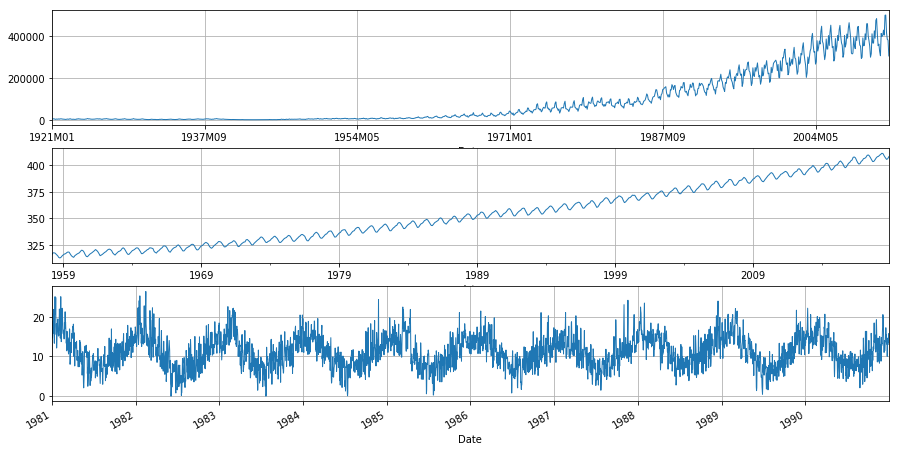

In [24]:
_, ax = plt.subplots(3, 1, figsize=(width, height))
passengers.plot(x=0, y=1, linewidth=line_width, ax=ax[0], grid=True)
oxygen.plot(x=0, y=1, linewidth=line_width, ax=ax[1], grid=True)
temperatures.plot(x=0, y=1, linewidth=line_width, ax=ax[2], grid=True)
plt.show()

<span class="text_common"><b>Основные выводы:</b> все эти ряды стационарными не являются. Первый - в связи с наичием тренда и гетероскедастичности (т.е. дисперсия значений различается в зависимости от времени). Второй ряд нестационарен по причине наличия тренда, а третий - по причине наличия в нём сезонности. Стоит также отметить, что первый и второй ряда также имеют сезонность (годовую).</span>

<h3>Как добиться стационарности?</h3><br>
<span class="text_common">Для стабилизации дисперсии применяют преобразования Бокса-Кокса, задаваемые следующим соотношением:</span>
$$\large{
  \hat{y_t} = \begin{cases}
    exp(\hat{y_t}'), \lambda=0\\
    (\lambda \hat{y_t}' + 1) ^ {\frac{1}{\lambda}}, \lambda \ne 0
  \end{cases}
}$$
<span class="text_common">Далее можно применить дифференцирование ряда, т.е. переход к попарным разностям соседних значений временного ряда. Данная операция убирает тренд из ряда. Математически это можно записать как:</span>
$$\large{
  y_1, ..., y_T \rightarrow y_2', ..., y_T',\\
  y_t' = y_t - y_{t-1}
}$$

<span class="text_common">Для проверки на стационарность используется тест Дики-Фуллера:</span>
```python
def dickey_fuller_test(time_series):
    dftest = adfuller(time_series, autolag='AIC')
    dfout = pd.Series(dftest[0:2], index=['Test statistic', 'p-value'])

    return dfout['Test statistic'], dfout['p-value']
```

<span class="text_common">Преобразуем временной ряд, характеризующий пассажиропоток (с первого графика в данном разделе), сначала с помощью преобразования Бокса-Кокса, а затем применим дифференцирование.</span>

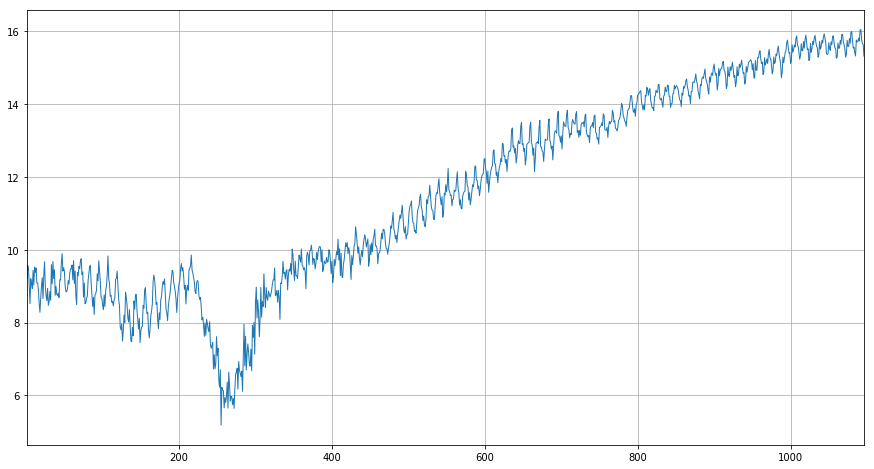

In [25]:
passengers_same_variance = pd.Series(boxcox(passengers)[0])[1:]
passengers_same_variance.plot(linewidth=line_width, grid=True)
plt.show()

In [26]:
dickey_fuller_test(passengers_same_variance.dropna())

Тест Дики-Фуллера: ряд нестационарный


<span class="text_common"><b>Основные выводы:</b> преобразования Бокса-Кокса, как сказано выше, действительно стабилизируют дисперсию временного ряда, но вот стационарным ряд не стал, что нам и показывает тест Дики-Фуллера.</span>

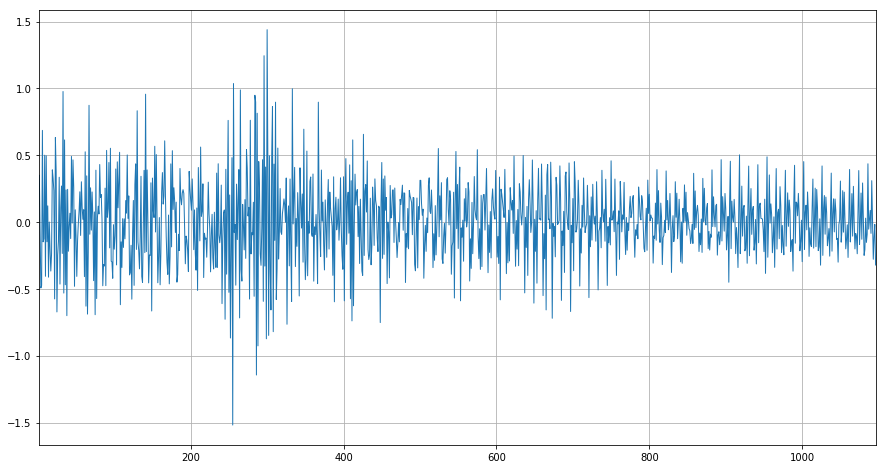

In [27]:
passengers_same_variance.diff().plot(linewidth=line_width, grid=True)
plt.show()

In [28]:
dickey_fuller_test(passengers_same_variance.diff().dropna())

Тест Дики-Фуллера: ряд стационарный


<span class="text_common"><b>Основные выводы:</b> после дифференцирования и преобразований Бокса-Кокса временной ряд стал больше похожим на стационарный. Стационарность формально доказывается с помощью теста Дики-Фуллера.</span>

<span class="text_common">Ещё одним методом приведения временного ряда к стационарному виду служит его декомпозиция с последующим удалением трендовой и сезонной составляющих. Рассмотрим данный метод на примере всё того же временного ряда с пасажиропотоком после применения преобразований Бокса-Кокса для стабиизации дисперсии</span>

In [29]:
# Подготовка данных для работы с 'seasonal_decompose'
df = pd.DataFrame(passengers_same_variance)
df['date'] = pd.to_datetime(pd.DatetimeIndex(freq='w', start=0, periods=len(df)))
df.set_index('date', inplace=True)

In [30]:
decomposition = seasonal_decompose(df)
resid = pd.Series([val[0] for val in decomposition.resid.dropna().values])

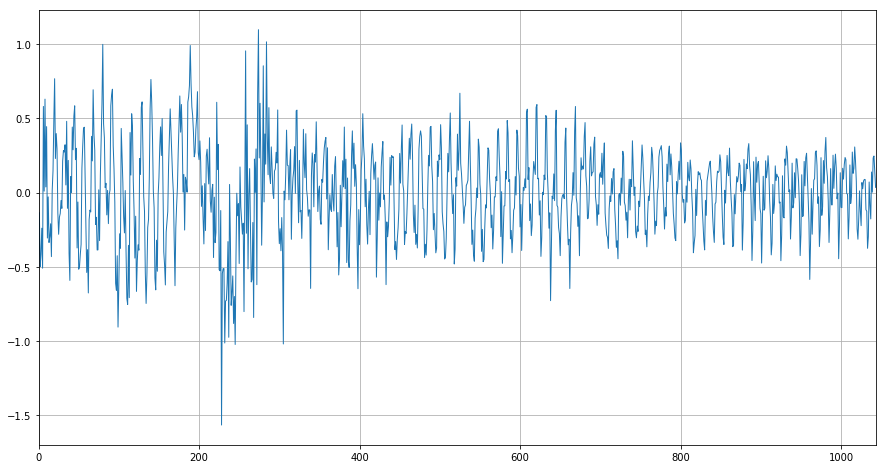

In [31]:
resid.plot(linewidth=line_width, grid=True)
plt.show()

In [32]:
dickey_fuller_test(resid)

Тест Дики-Фуллера: ряд стационарный


<span class="text_common"><b>Основные выводы:</b> после применения преобразований Бокса-Кокса и последующего удаления трендовой и сезонной компонент временной ряд стал стационарным, что видно как визуально, так и по результатам статистического теста Дики-Фуллера.</span>